In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [25]:
# Clean up the dataset
print(df['STATIONS_ID'].unique())
df = df.drop(['STATIONS_ID'], 1)
df.dropna(inplace=True)
df

[1766]


/tmp/ipykernel_2182/1726528945.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['STATIONS_ID'], 1)


,DATUM,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1,13.5,90.0,0.8,9.4,104


In [26]:
reindexed_df = df.copy()
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()

reindexed_df

,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,
1991-01-01,10.0,3.900000,86.000000,0.3,2.9,102.0
1991-01-02,10.0,9.200000,90.666667,1.4,6.3,110.0
1991-01-03,10.0,7.733333,82.333333,1.0,6.6,110.0
1991-01-04,10.0,6.433333,76.666667,1.2,5.5,106.0
1991-01-05,10.0,5.466667,78.000000,1.0,3.7,109.0
...,...,...,...,...,...,...
2021-12-27,1.0,3.050000,87.750000,0.1,-0.1,97.0
2021-12-28,1.0,6.700000,92.250000,0.2,0.5,104.0
2021-12-29,1.0,7.900000,96.250000,0.3,5.4,107.0


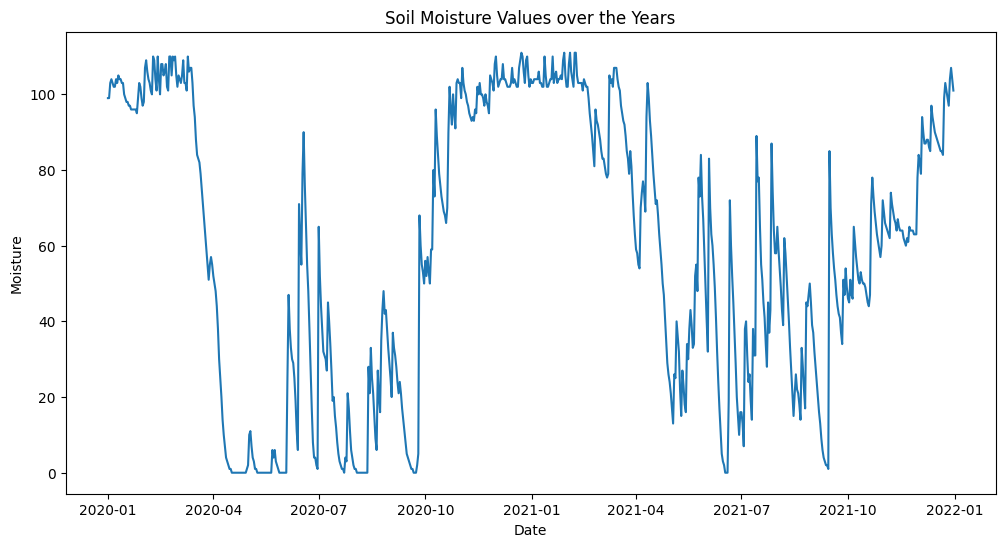

In [27]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2020-01-01':])

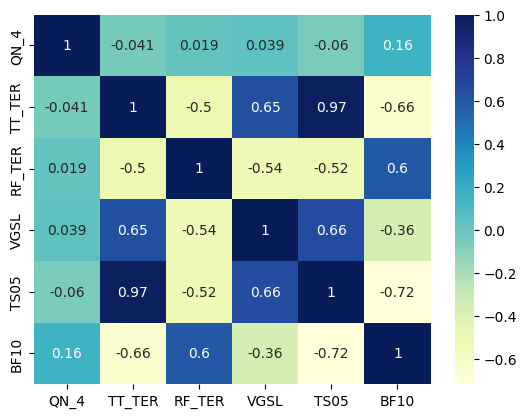

In [28]:
sns.heatmap(reindexed_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

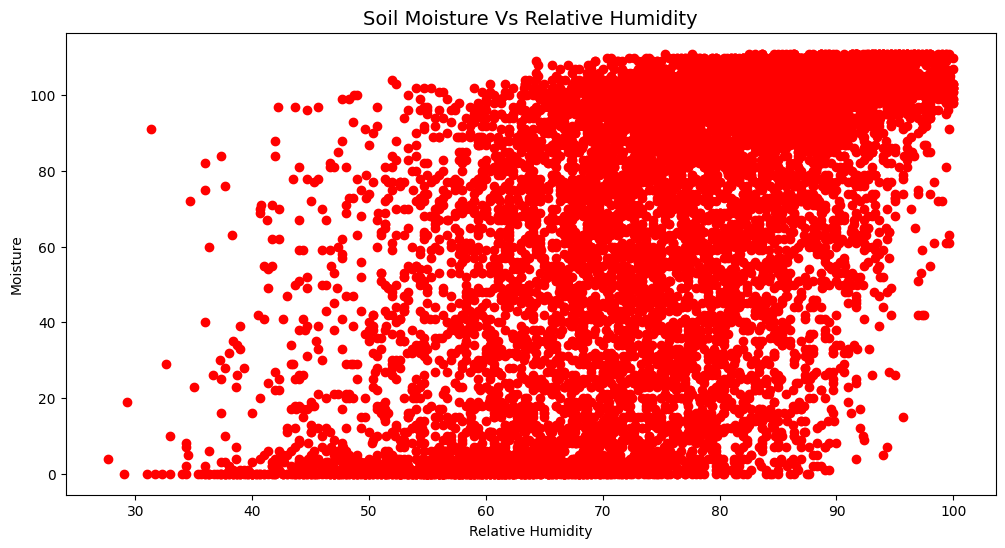

In [29]:
reindexed_df = reindexed_df[reindexed_df.RF_TER > 0]

plt.figure(figsize=(12,6))
plt.scatter(x = reindexed_df['RF_TER'], y = reindexed_df['BF10'], color='red')
plt.title('Soil Moisture Vs Relative Humidity', fontsize=14)
plt.xlabel('Relative Humidity')
plt.ylabel('Moisture')
plt.show()

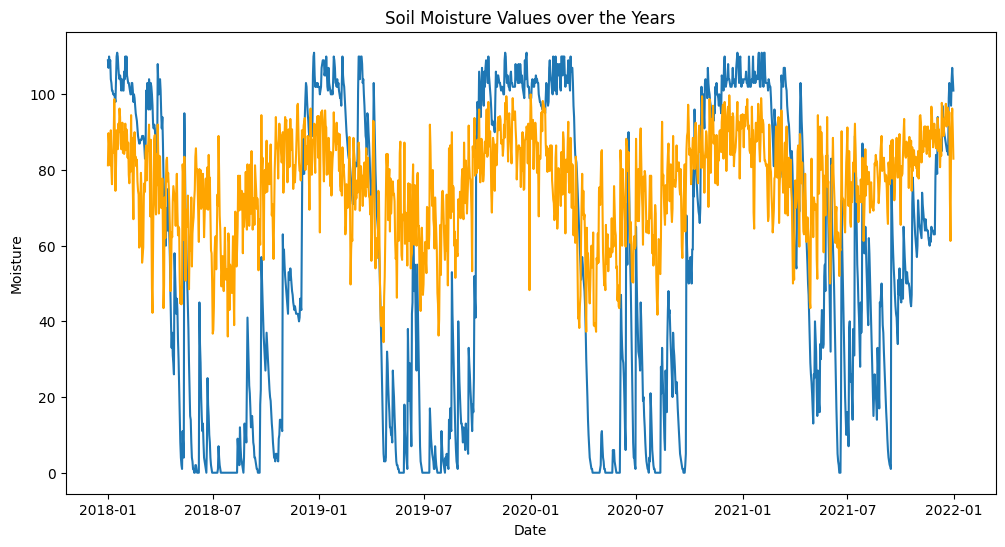

In [30]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2018':])
plt.plot(reindexed_df['RF_TER']['2018':], c='orange')

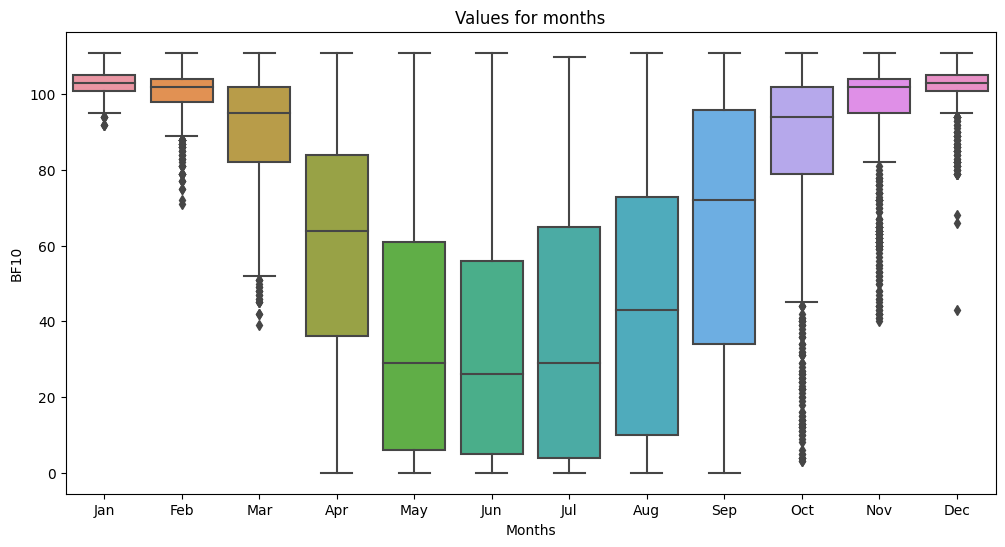

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=reindexed_df.index.strftime("%b"), y=reindexed_df["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

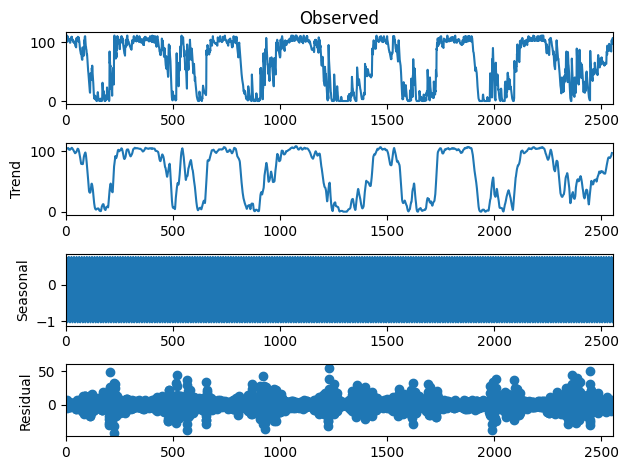

In [32]:
analysis = seasonal_decompose(reindexed_df["BF10"]['2015':].values, model="additive", period=12)

analysis.plot()
plt.show()

In [56]:
future_days = 30

df2 = reindexed_df[['BF10']]
df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)
df2

/tmp/ipykernel_2182/1346759709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)


,BF10,BF10-Shifted
DATUM,,
1991-01-01,102.0,98.0
1991-01-02,110.0,97.0
1991-01-03,110.0,97.0
1991-01-04,106.0,97.0
1991-01-05,109.0,97.0
...,...,...
2021-12-27,97.0,NaN
2021-12-28,104.0,NaN
2021-12-29,107.0,NaN


In [79]:
# Dropping columns we won't be using for the predictions of closing price
X = df2[['BF10']][:-future_days]

# Getting just the closing price column
y = df2['BF10-Shifted'][:-future_days]

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2, random_state=random_seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=random_seed)

print("", X_train.shape, "\n", y_train.shape, 
      "\n", X_val.shape, "\n", y_val.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (9033, 1) 
 (9033,) 
 (1130, 1) 
 (1130,) 
 (1129, 1) 
 (1129,)


In [80]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

TIME_WINDOW=100
FORECAST_DISTANCE=30

X_train, X_else = train_test_split(reindexed_df[['BF10']], test_size=0.2, shuffle=False, random_state=69)
X_valid, X_test= train_test_split(X_else, test_size=0.5, shuffle=False, random_state=69)

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values.flatten()],[X_train.values.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values.flatten()],[X_valid.values.flatten()])
X_test_rolled, y_test_rolled,_=segmenter.fit_transform([X_test.values.flatten()],[X_test.values.flatten()])

X_train_rolled.shape, y_train_rolled.shape

((8928, 100), (8928,))

In [81]:
# Warning, Keras needs a 1D matrix, not a vector, so one must do:

X_train_rolled = X_train_rolled[:,:, np.newaxis]
X_valid_rolled = X_valid_rolled[:,:, np.newaxis]
X_test_rolled = X_test_rolled[:,:, np.newaxis]

## SHAPE: (samples, timesteps, variables)
print(X_train_rolled.shape)

(8928, 100, 1)


In [90]:
N_CELLS = 100
KERNEL = 'GlorotNormal'

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (X_train_rolled.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 100, 100)          40800     
                                                                 
 dropout_64 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_65 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_65 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_66 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_66 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_67 (LSTM)              (None, 100)             

In [91]:
from tensorflow.keras import backend as be

be.clear_session()

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='loss',patience=3)

# Fitting the RNN to the Training set
history = model.fit(X_train_rolled, y_train_rolled,
                    epochs = 20,
                    validation_data = (X_valid_rolled,y_valid_rolled),
                    batch_size = 100,
                    shuffle = False,
                    callbacks=[my_callback])

Epoch 1/20
90/90 [==============================] - 40s 357ms/step - loss: 4838.8652 - val_loss: 3167.2397
Epoch 2/20
90/90 [==============================] - 30s 335ms/step - loss: 3771.6904 - val_loss: 2612.5090
Epoch 3/20
90/90 [==============================] - 31s 347ms/step - loss: 3087.0955 - val_loss: 2219.2483
Epoch 4/20
90/90 [==============================] - 32s 349ms/step - loss: 2570.3010 - val_loss: 1955.8619
Epoch 5/20
90/90 [==============================] - 30s 337ms/step - loss: 2194.1826 - val_loss: 1787.7498
Epoch 6/20
90/90 [==============================] - 31s 339ms/step - loss: 1915.1199 - val_loss: 1689.4659
Epoch 7/20
90/90 [==============================] - 31s 346ms/step - loss: 1721.9871 - val_loss: 1640.6196
Epoch 8/20
90/90 [==============================] - 30s 336ms/step - loss: 1578.4536 - val_loss: 1625.2267
Epoch 9/20
90/90 [==============================] - 31s 341ms/step - loss: 1486.5446 - val_loss: 1631.0035
Epoch 10/20
90/90 [==================

: 

: 

Maximum Loss : 3794.5198

Minimum Loss : 1309.3530

Loss difference : 2485.1667


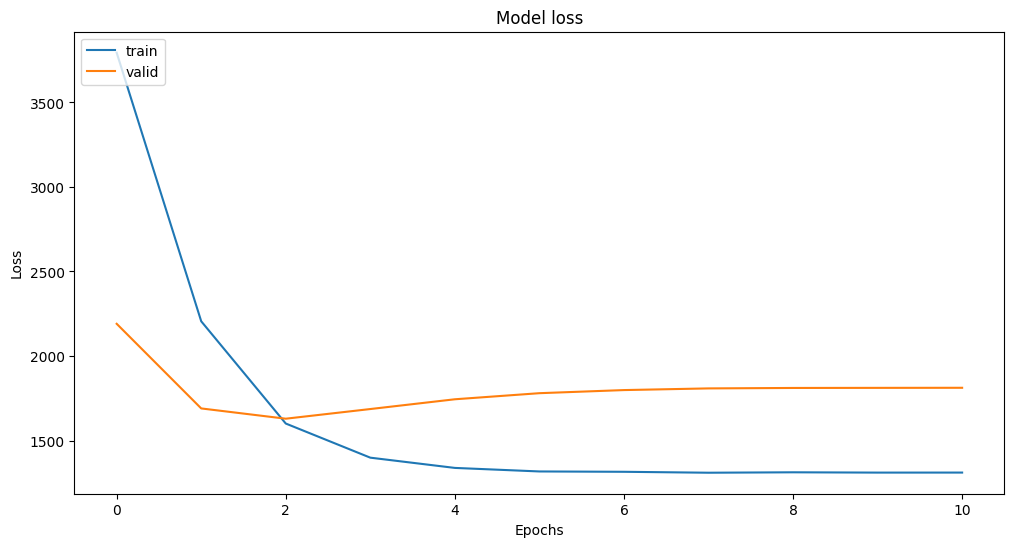

In [ ]:
# Plot the accuracy and loss
plt.figure(figsize=(12,6))
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'], loc='upper left')

max_loss = np.max(history.history['loss'])
min_loss = np.min(history.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

In [88]:
predictions = model.predict(y_test)
predictions

36/36 [==============================] - 1s 2ms/step


array([[3.9092321],
       [3.9048421],
       [3.9025793],
       ...,
       [3.6255805],
       [3.612017 ],
       [3.5976534]], dtype=float32)

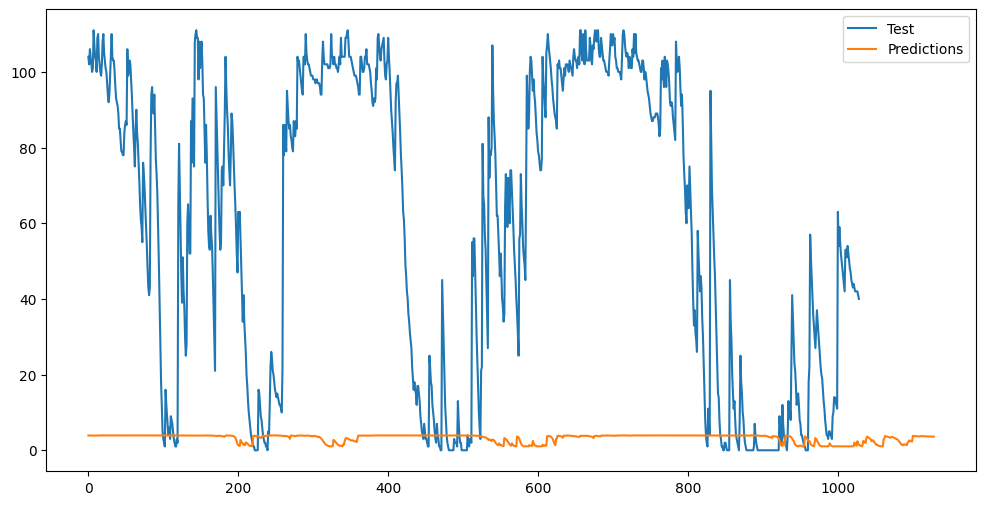

In [89]:
plt.figure(figsize=(12,6))
plt.plot(list(y_test[100:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()